In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 

# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)

# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

## Grid Search $\alpha$

### With analytical wave function

In [9]:
N = 500      # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 20000
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions = safe_initial_positions(wf, alpha, N, dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=20000,
                            tune=True,
                            tune_iter=100000,
                            tune_interval=5000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 142.9989731311798


In [10]:
df = pd.concat(results, ignore_index=True)
df

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,500,3,0.1,1896.976216,72.512284,0.34195
1,500,3,0.2,1179.424006,67.315411,0.29450
2,500,3,0.3,867.425591,18.963470,0.24520
3,500,3,0.4,788.421624,18.394234,0.49750
4,500,3,0.5,750.000000,0.000000,0.32985
5,500,3,0.6,756.066685,5.485269,0.28025
6,500,3,0.7,813.009495,10.033947,0.37480
7,500,3,0.8,814.399409,22.297948,0.33115
8,500,3,0.9,970.361322,11.013987,0.33230
9,500,3,1.0,659.143929,39.254812,0.23670


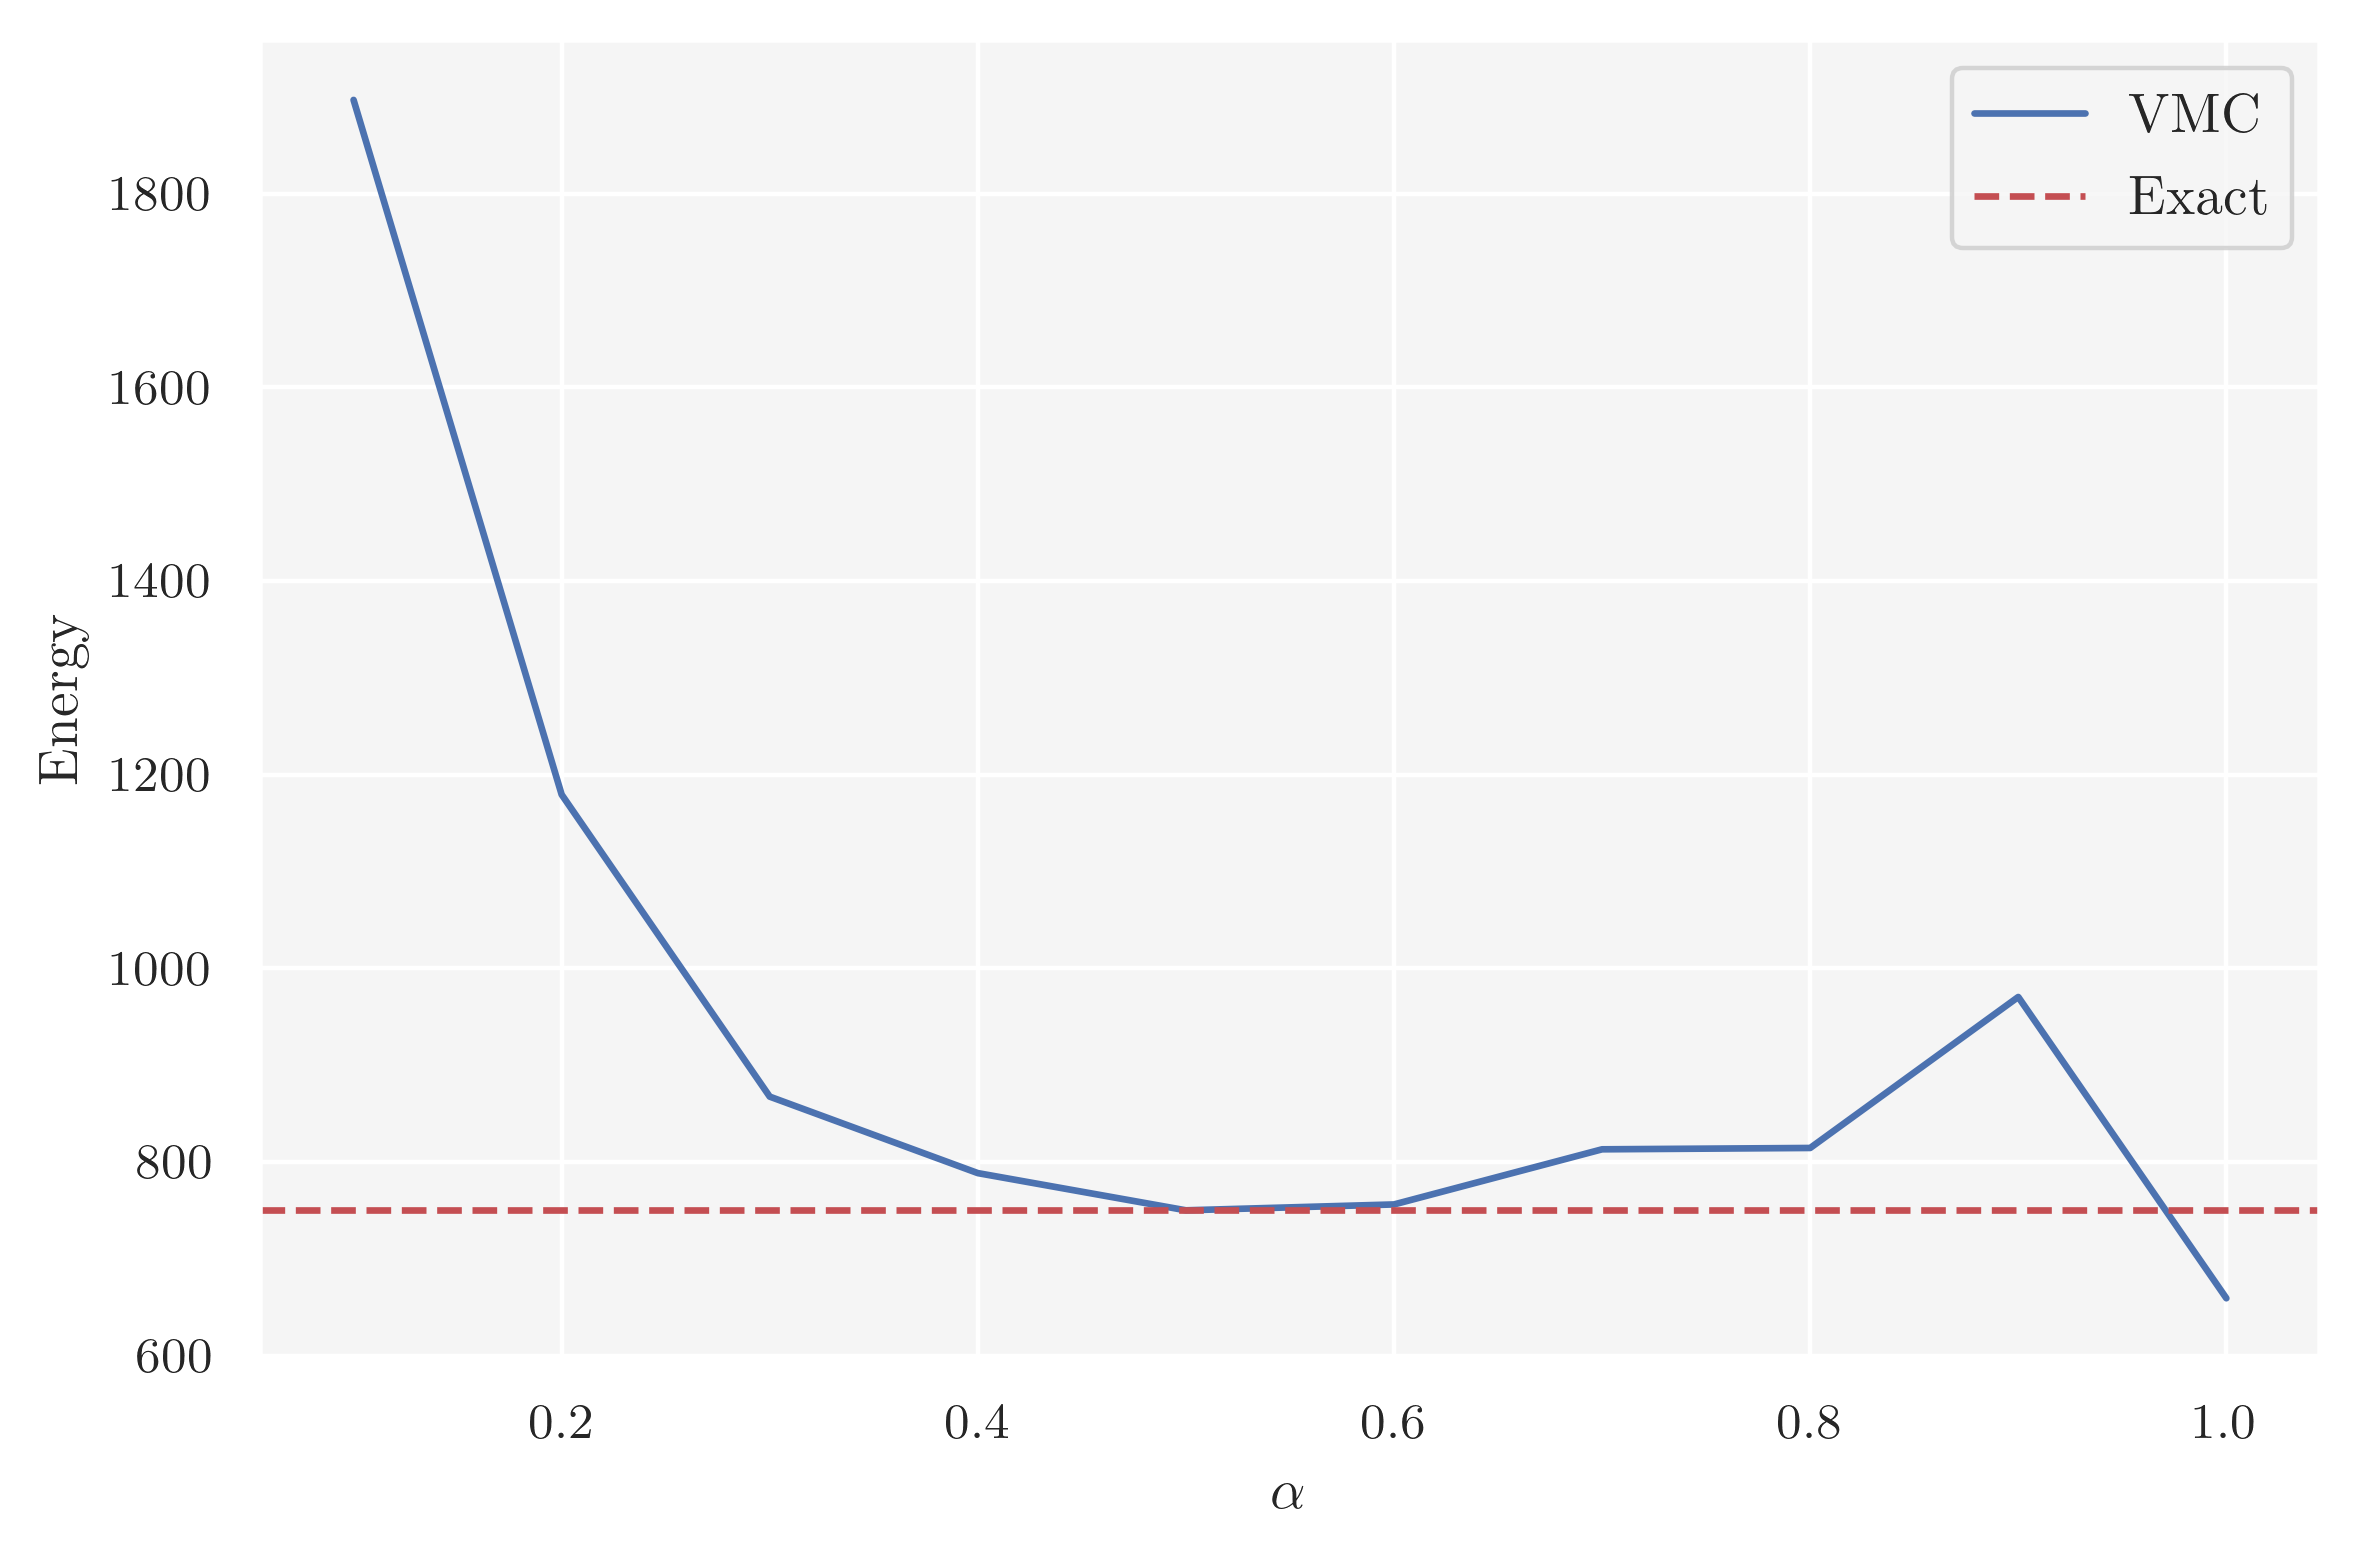

In [11]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(exact_E, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel='Energy')
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical.pdf"), bbox_inches='tight')

### With numerical wave function

In [6]:
N = 500      # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.LogNIB(omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 10000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions = safe_initial_positions(wf, alpha, N, dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=5000,
                            tune_interval=250,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 84.3462381362915


In [7]:
df = pd.concat(results, ignore_index=True)
df

,nparticles,dim,alpha,energy,standard_error,accept_rate
0,500,3,0.10,1955.176167,2.335322e+01,0.4899686
1,500,3,0.15,1344.983590,9.870768e+00,0.48677287
2,500,3,0.20,1085.069047,8.166454e+00,0.4738222
3,500,3,0.25,951.622179,5.289779e+00,0.4759352
4,500,3,0.30,854.110162,2.379428e+00,0.5092343
5,500,3,0.35,792.347210,4.121130e+00,0.5079416
6,500,3,0.40,768.954861,1.199531e+00,0.4865962
7,500,3,0.45,756.230913,8.743841e-01,0.5033691
8,500,3,0.50,750.000000,1.921048e-07,0.4946612
9,500,3,0.55,754.252768,1.056547e+00,0.5068557


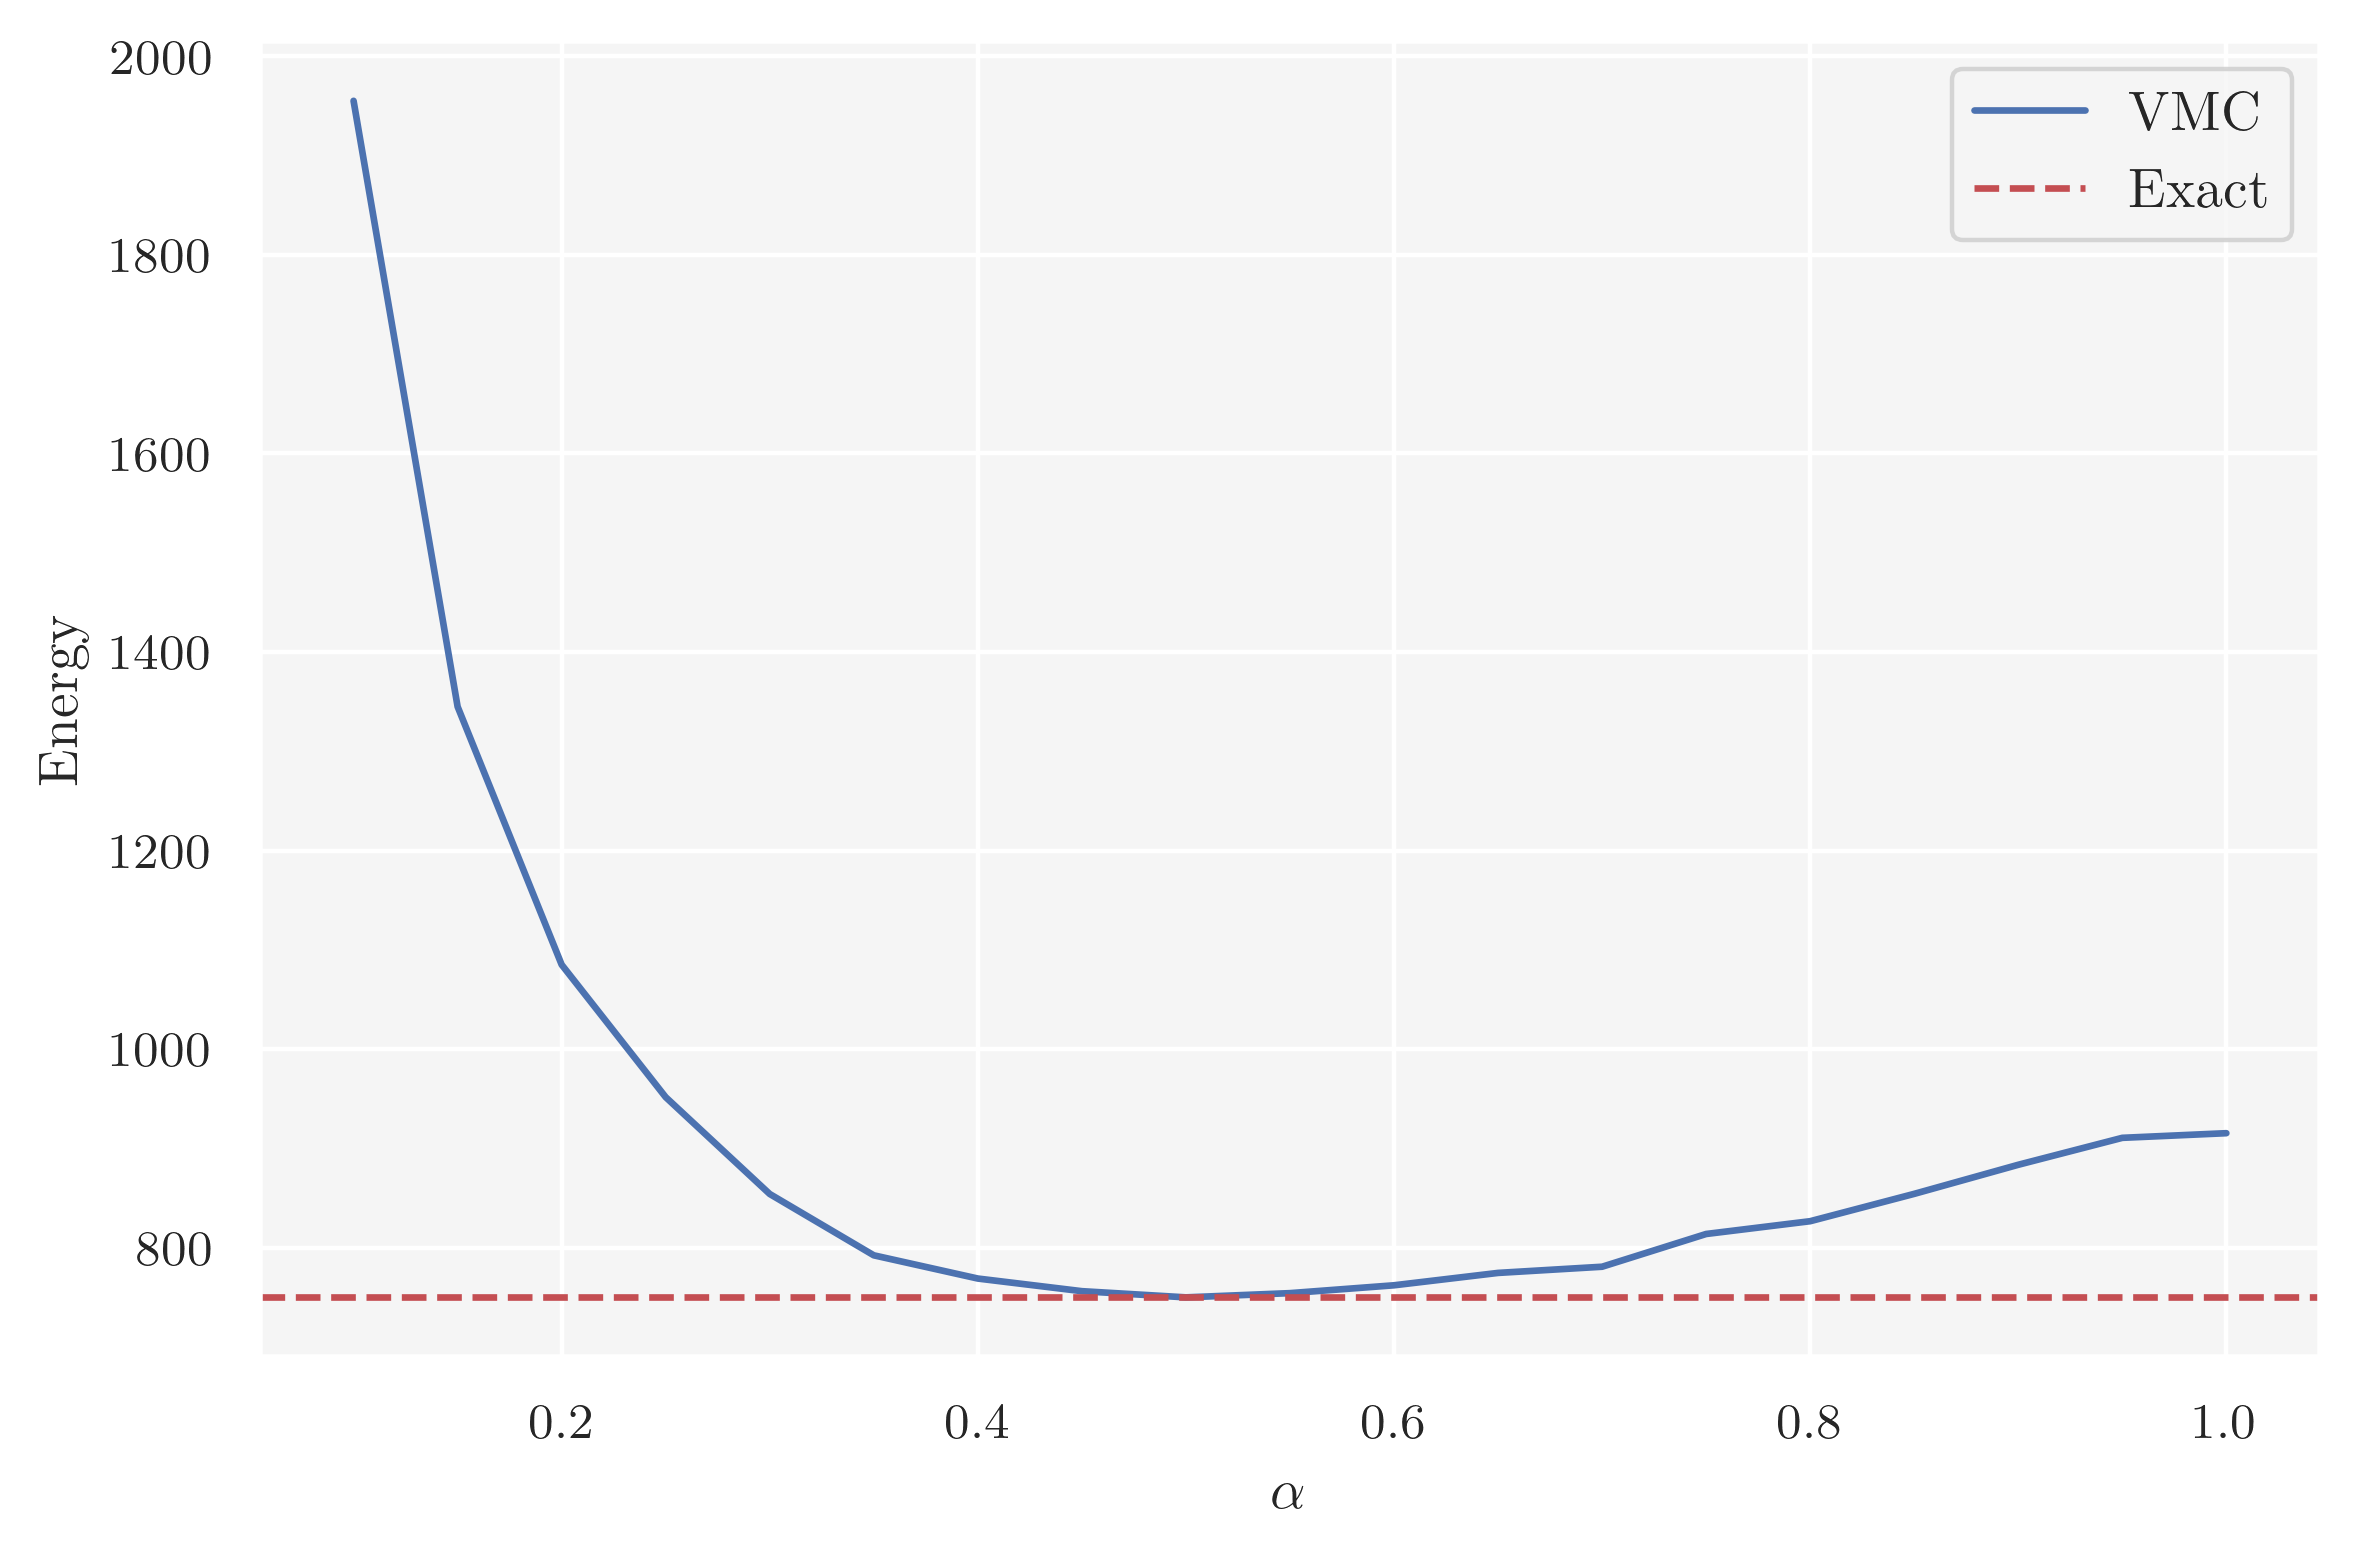

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df, x="alpha", y="energy", ax=ax, label="VMC")
ax.axhline(exact_E, ls='--', color='r', label='Exact')
ax.set(xlabel=r'$\alpha$', ylabel='Energy')
ax.legend()
fig.savefig(fig_path("grid_search_numerical.pdf"), bbox_inches='tight')

plt.show()

## Optimize

Set `nchains = -1` for automatic detection of available CPUs. Note that only half of the found CPUs will be used as we assume half of the CPUs are only hardware threads and ignore those. 

In [9]:
nchains = 16
#nchains = -1

### With analytical wave function

#### Metropolis

In [10]:
N = 500      # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Instantiate wave function
wf = vmc.NIBWF(N, dim, omega)

# Set intial positions
initial_positions = safe_initial_positions(wf, alpha, N, dim)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 20000
initial_alpha = 0.4

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         nchains=nchains,
                         seed=None,
                         warm=True,
                         warmup_iter=500,
                         tune=True,
                         tune_iter=5000,
                         tune_interval=250,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=50000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         scale=1.0
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 20.847171783447266


In [11]:
df = sampler.results_all
df

,nparticles,dim,scale,eta,alpha,energy,standard_error,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,500,3,1.771561,0.01,0.499111,750.016330,0.010862,0.423162,20000,67500,500,2000,45000
1,500,3,1.771561,0.01,0.493826,749.911324,0.084067,0.423025,20000,45500,500,2000,23000
2,500,3,1.610510,0.01,0.498708,750.030310,0.009622,0.451516,20000,63750,500,1750,41500
3,500,3,1.610510,0.01,0.490068,750.314105,0.110464,0.459137,20000,46250,500,1750,24000
4,500,3,1.610510,0.01,0.501062,749.984856,0.008706,0.459993,20000,66750,500,1750,44500
5,500,3,1.610510,0.01,0.498741,750.064273,0.016411,0.455243,20000,65750,500,1750,43500
6,500,3,1.610510,0.01,0.501200,750.022227,0.012716,0.460670,20000,67250,500,1750,45000
7,500,3,1.610510,0.01,0.500343,749.992864,0.004242,0.457278,20000,72250,500,1750,50000
8,500,3,1.610510,0.01,0.493616,750.087081,0.070456,0.462481,20000,48250,500,1750,26000
9,500,3,1.610510,0.01,0.494100,750.012824,0.057739,0.455337,20000,49250,500,1750,27000


In [12]:
exact_E = exact_energy(N, dim, omega)
energy_mean = results["energy"].mean()
error_mean = results["standard_error"].mean()
print(f"Exact energy: {exact_E}")
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")

Exact energy: 750.0
VMC energy: 750.014075124068
VMC error: 0.030404844748837482


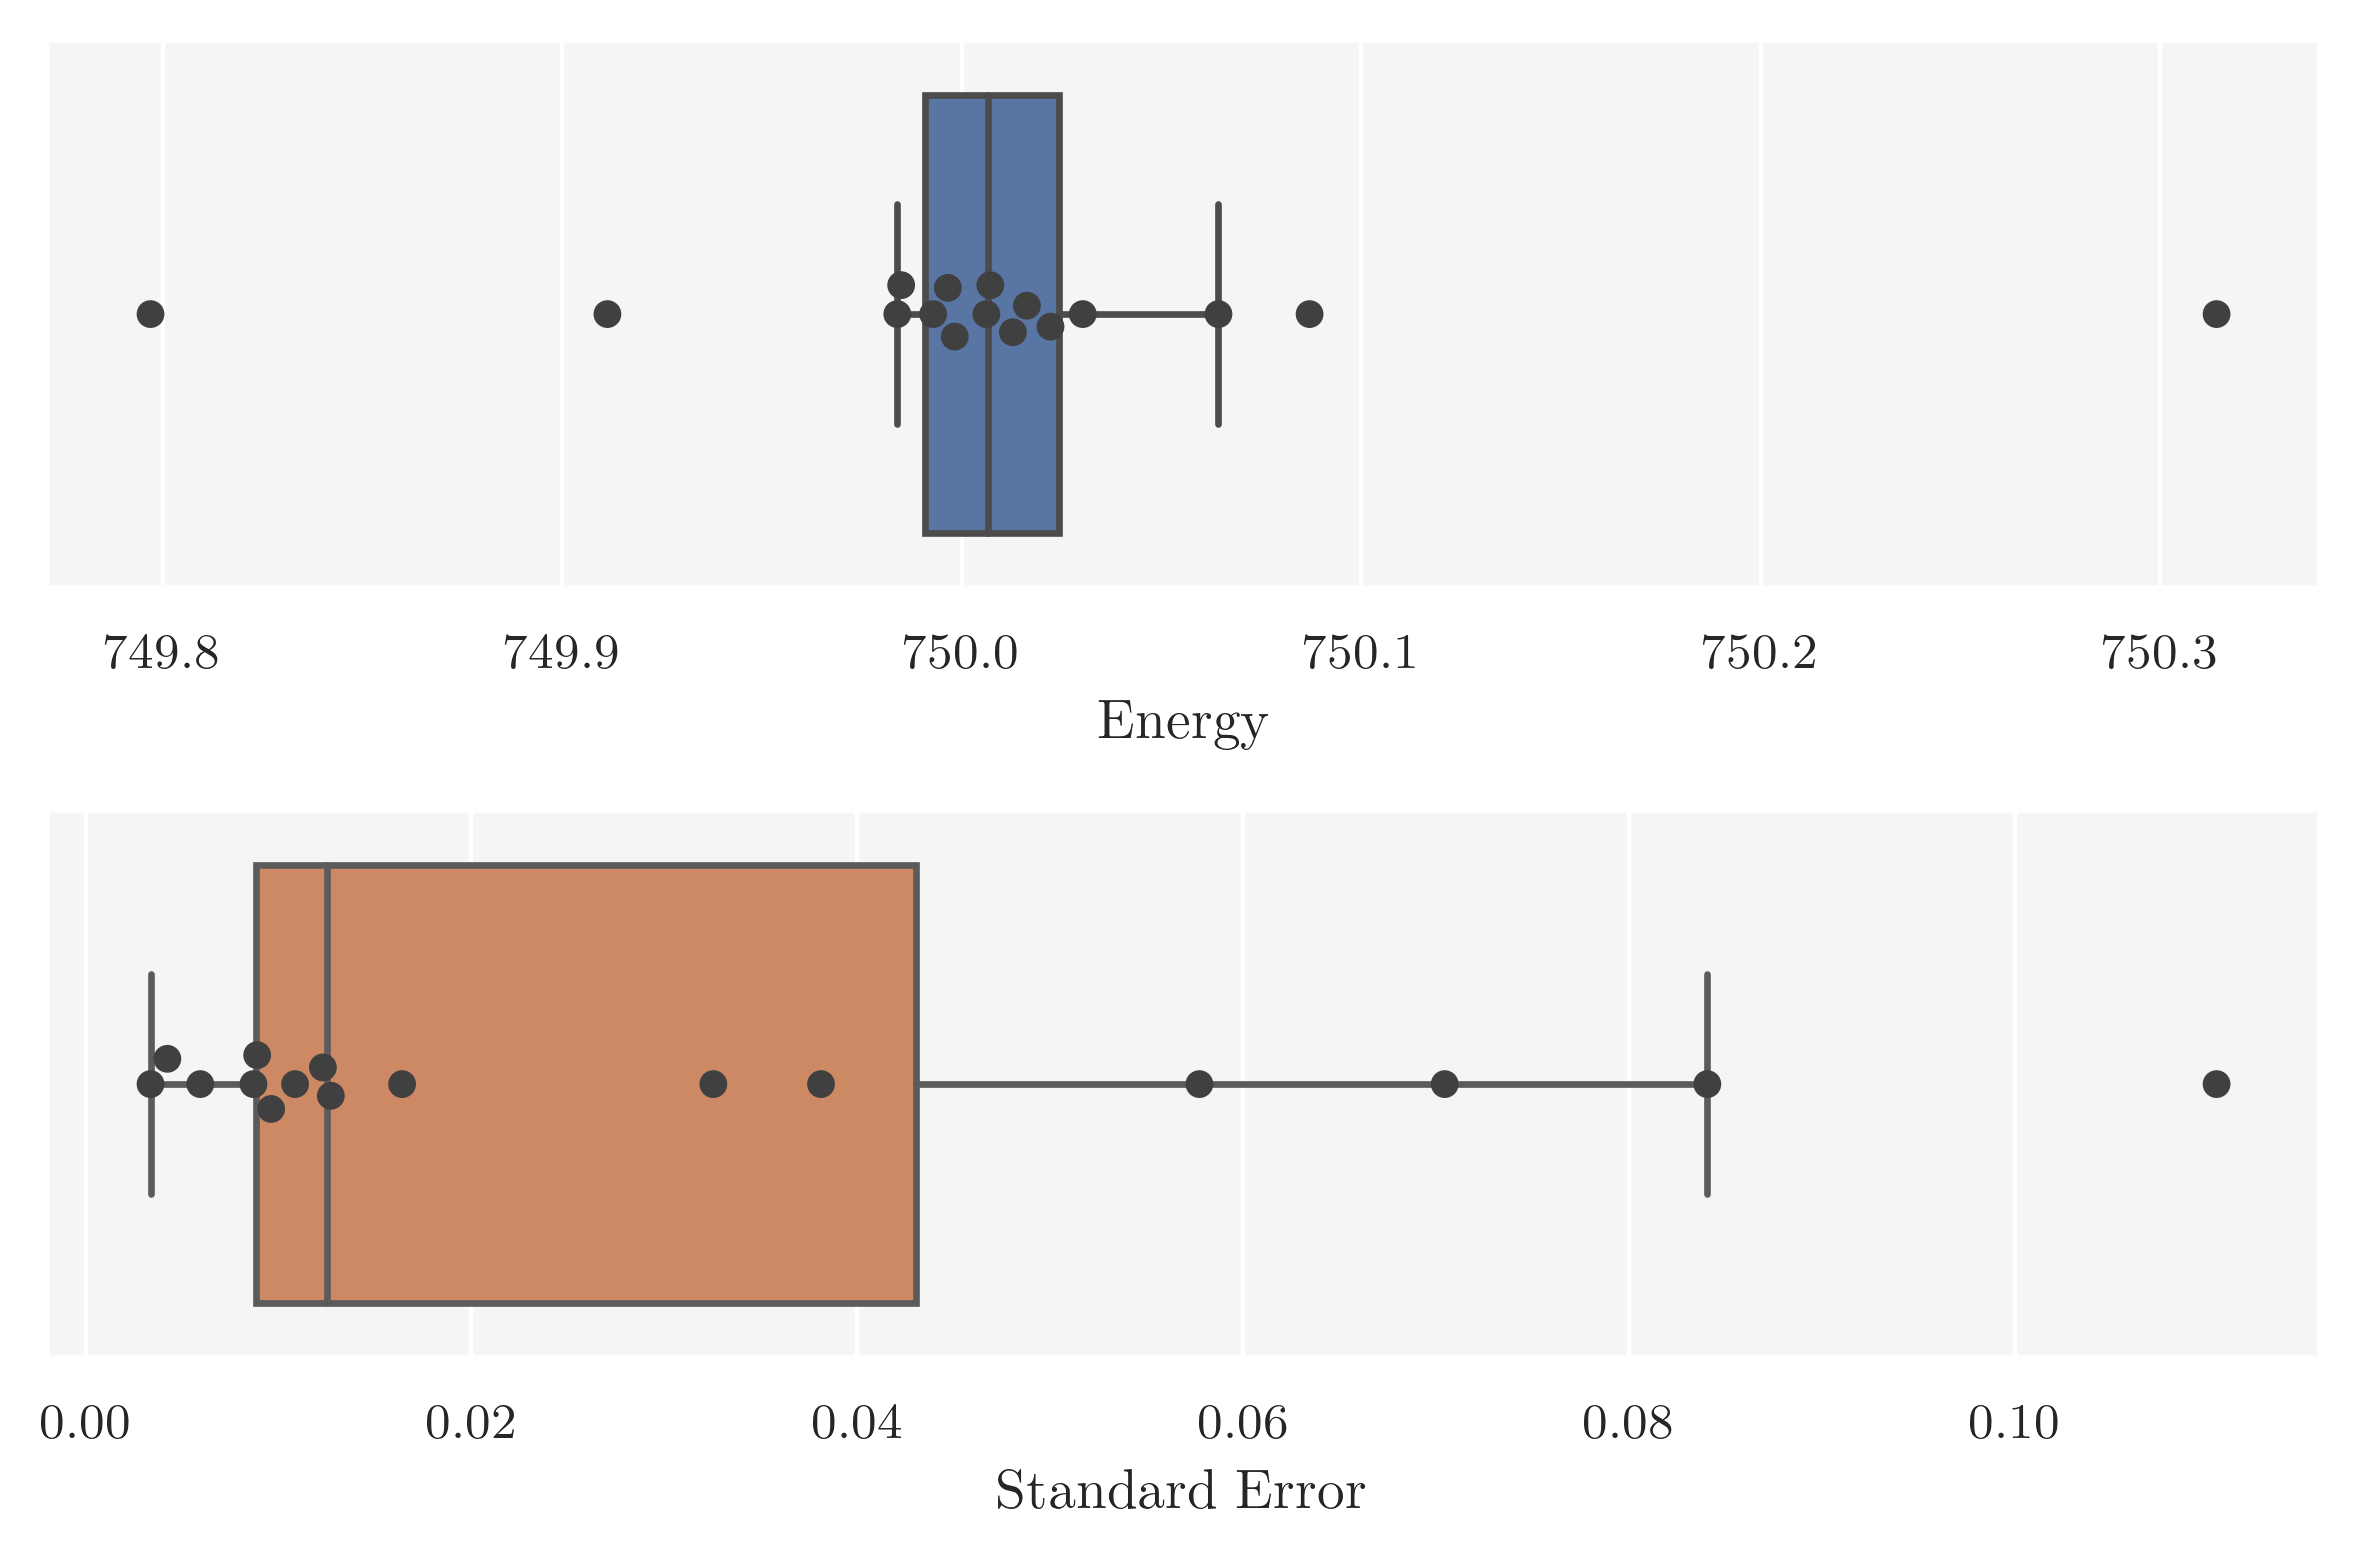

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_analytical_metropolis.pdf"), bbox_inches='tight')

plt.show()

#### Metropolis-Hastings

In [14]:
N = 500      # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Instantiate wave function
wf = vmc.NIBWF(N, dim, omega)

# Set intial positions
initial_positions = safe_initial_positions(wf, alpha, N, dim)

# Instantiate sampler
sampler = vmc.samplers.MetropolisHastings(wf)

# Config
nsamples = 20000
initial_alpha = 0.4

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         nchains=nchains,
                         seed=None,
                         warm=True,
                         warmup_iter=500,
                         tune=True,
                         tune_iter=5000,
                         tune_interval=250,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=50000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         dt=0.5
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 22.94610095024109


In [15]:
df = sampler.results_all
df

,nparticles,dim,dt,eta,alpha,energy,standard_error,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,500,3,1.296871,0.01,0.526226,751.568524,0.294585,0.666935,20000,32250,500,1750,10000
1,500,3,1.296871,0.01,0.500542,750.008937,0.005635,0.690877,20000,72250,500,1750,50000
2,500,3,1.296871,0.01,0.499724,749.991381,0.002809,0.698815,20000,72250,500,1750,50000
3,500,3,1.296871,0.01,0.519900,751.146519,0.193186,0.678493,20000,31750,500,1750,9500
4,500,3,1.296871,0.01,0.500595,750.013075,0.005523,0.694331,20000,71750,500,1750,49500
5,500,3,1.296871,0.01,0.500069,749.999767,0.000591,0.691130,20000,72250,500,1750,50000
6,500,3,1.296871,0.01,0.499342,749.994992,0.004058,0.688558,20000,70250,500,1750,48000
7,500,3,1.296871,0.01,0.500889,750.014156,0.005636,0.694836,20000,59750,500,1750,37500
8,500,3,1.296871,0.01,0.497501,749.952357,0.016413,0.696019,20000,52750,500,1750,30500
9,500,3,1.296871,0.01,0.499496,749.987867,0.003424,0.695866,20000,67250,500,1750,45000


In [16]:
exact_E = exact_energy(N, dim, omega)
energy_mean = results["energy"].mean()
error_mean = results["standard_error"].mean()
print(f"Exact energy: {exact_E}")
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")

Exact energy: 750.0
VMC energy: 750.1762336627759
VMC error: 0.039161621714717244


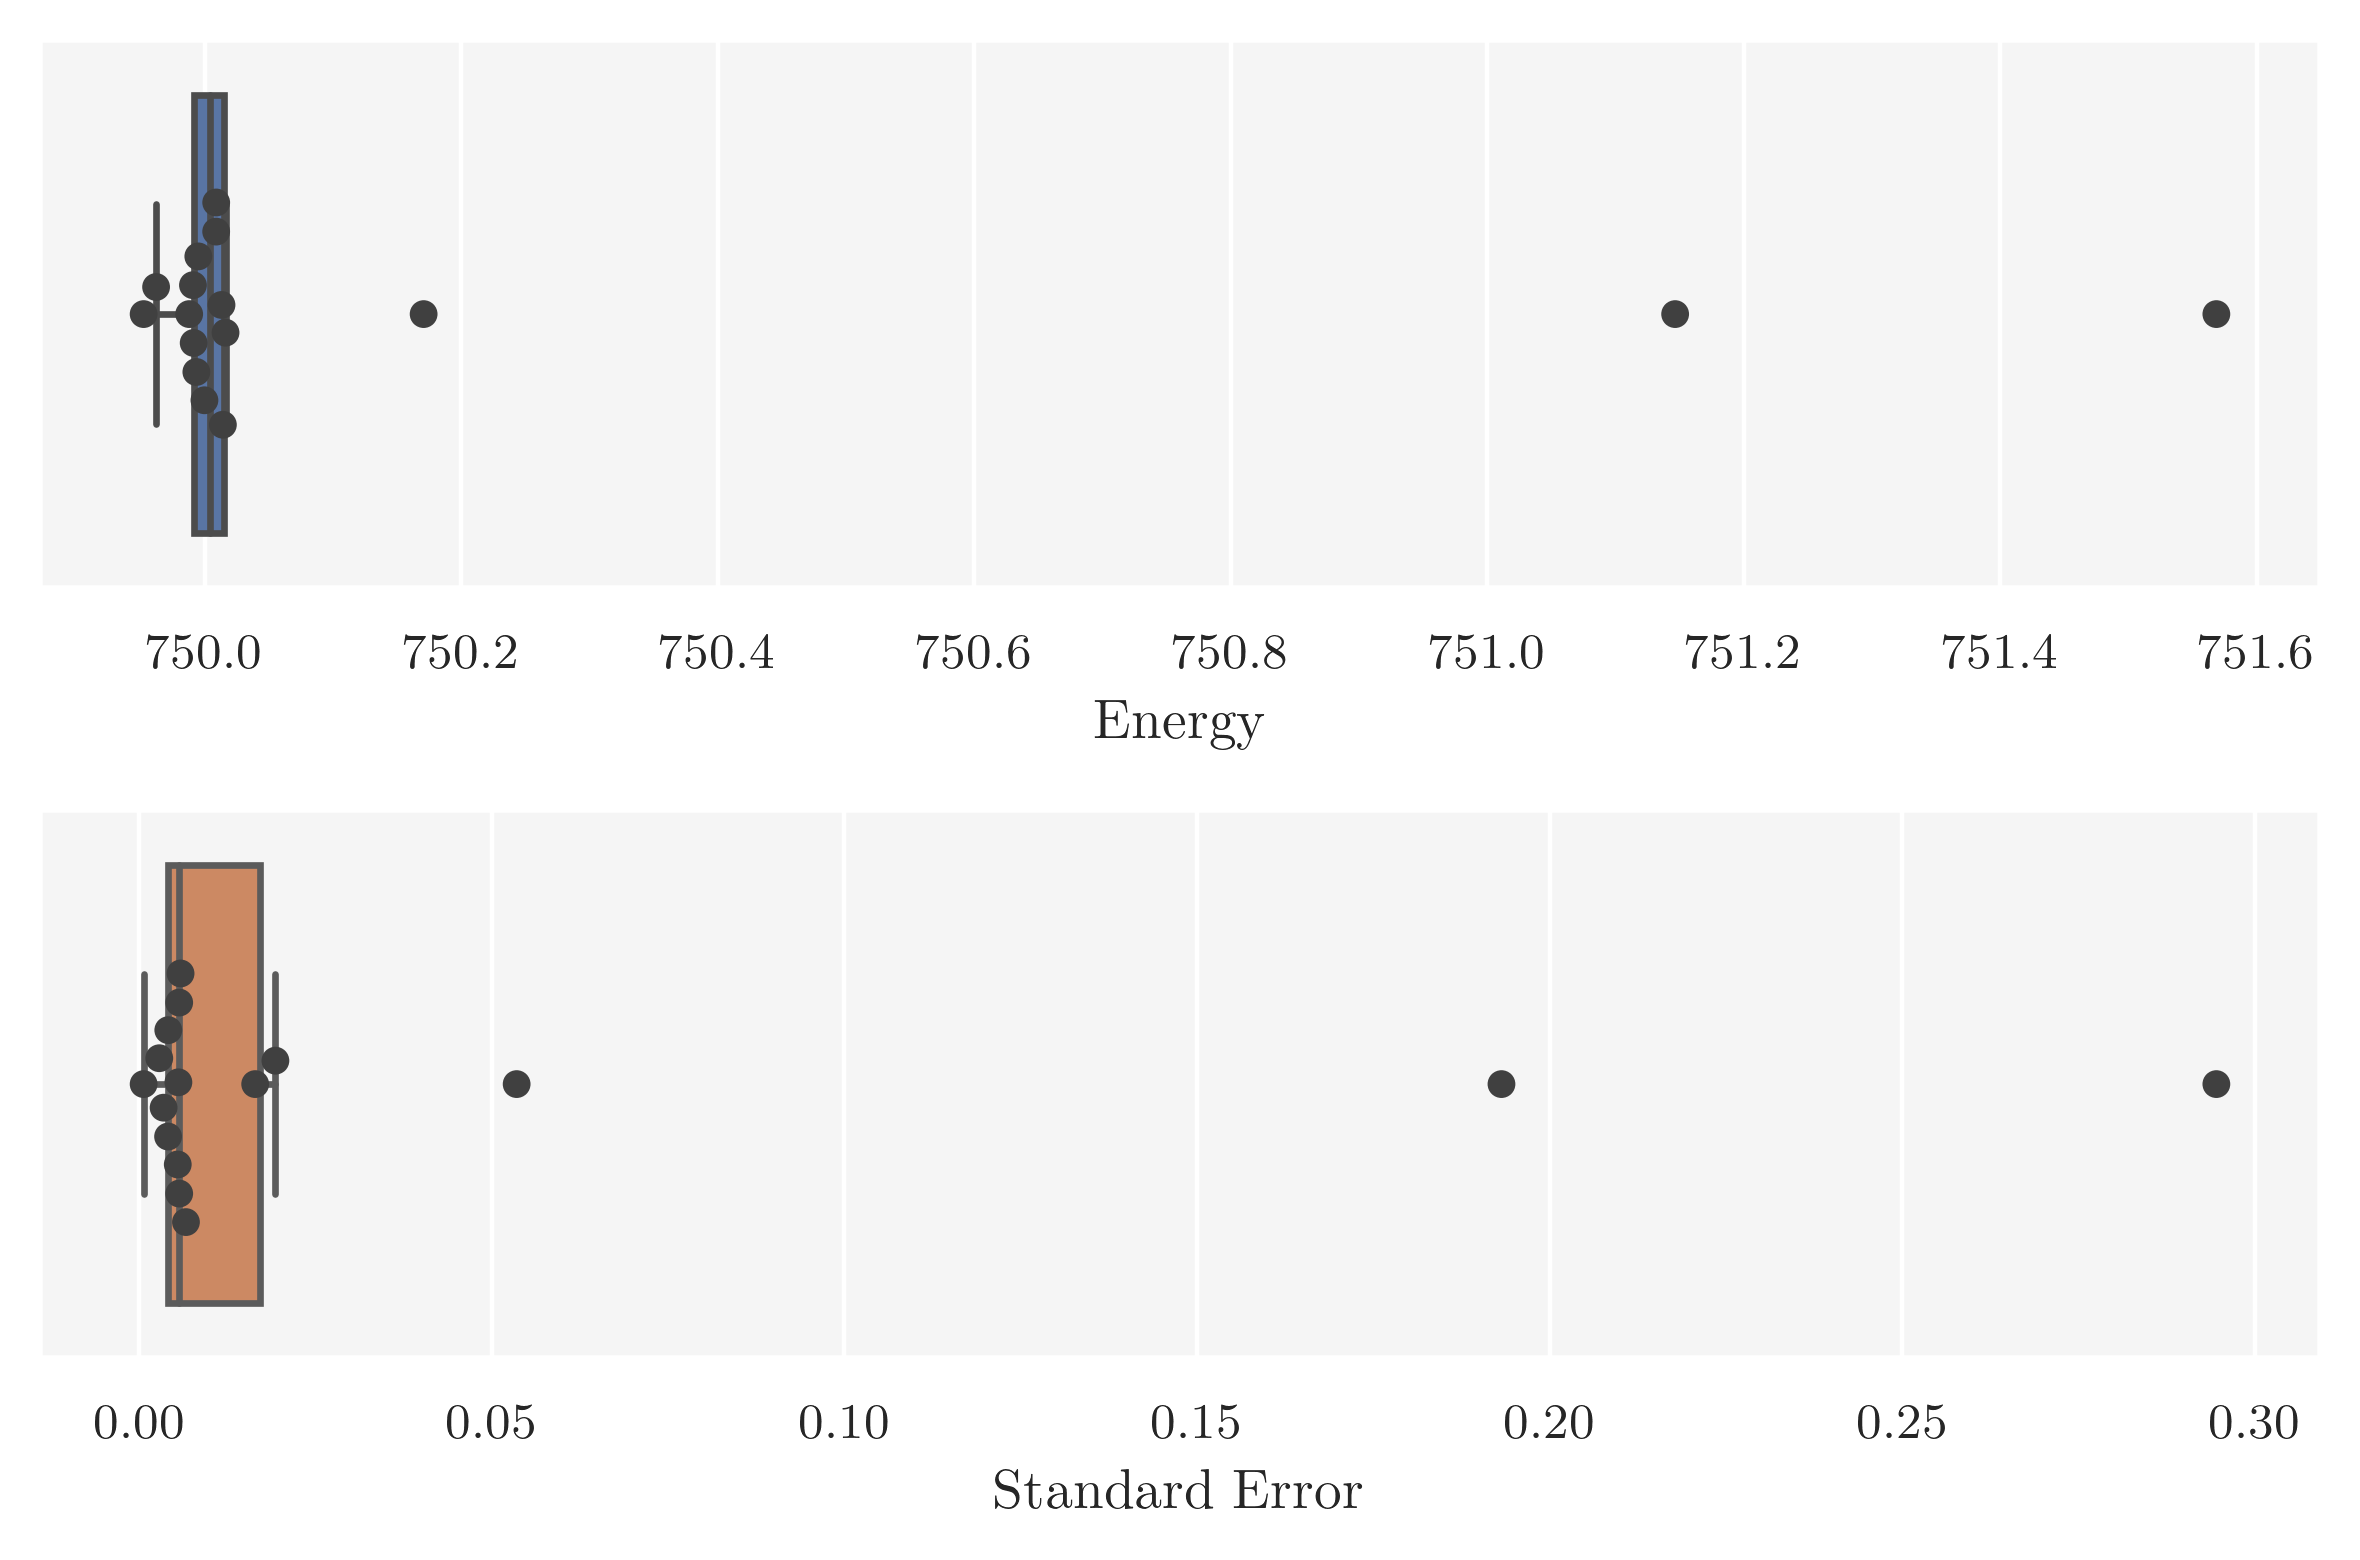

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_analytical_metropolis_hastings.pdf"), bbox_inches='tight')

plt.show()

### With numerical wave function

#### Metropolis

In [18]:
N = 500      # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Instantiate wave function
wf = vmc.LogNIB(omega)

# Set intial positions
initial_positions = safe_initial_positions(wf, alpha, N, dim)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 20000
initial_alpha = 0.4

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         nchains=nchains,
                         seed=None,
                         warm=True,
                         warmup_iter=500,
                         tune=True,
                         tune_iter=5000,
                         tune_interval=250,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=50000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         scale=1.0
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 60.836605072021484


In [19]:
df = sampler.results_all
df

,nparticles,dim,scale,eta,alpha,energy,standard_error,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,500,3,1.610510,0.01,0.502408,750.008847,0.020153,0.4519025,20000,58250,500,1750,36000
1,500,3,1.610510,0.01,0.500538,749.986479,0.003547,0.4526224,20000,72250,500,1750,50000
2,500,3,1.610510,0.01,0.497953,750.050533,0.031814,0.45823783,20000,62750,500,1750,40500
3,500,3,1.610510,0.01,0.490551,750.178152,0.092403,0.4585661,20000,43250,500,1750,21000
4,500,3,1.610510,0.01,0.500483,750.012299,0.005688,0.45623818,20000,72250,500,1750,50000
5,500,3,1.610510,0.01,0.499061,750.033896,0.010786,0.45877853,20000,69250,500,1750,47000
6,500,3,1.610510,0.01,0.502553,750.059939,0.031677,0.45557818,20000,57250,500,1750,35000
7,500,3,1.610510,0.01,0.499840,750.006296,0.001572,0.4482599,20000,72250,500,1750,50000
8,500,3,1.610510,0.01,0.497994,750.039138,0.024168,0.45488638,20000,58750,500,1750,36500
9,500,3,1.610510,0.01,0.501932,749.972630,0.021016,0.4510815,20000,58750,500,1750,36500


In [20]:
exact_E = exact_energy(N, dim, omega)
energy_mean = results["energy"].mean()
error_mean = results["standard_error"].mean()
print(f"Exact energy: {exact_E}")
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")

Exact energy: 750.0
VMC energy: 750.0502145887374
VMC error: 0.022278461738464775


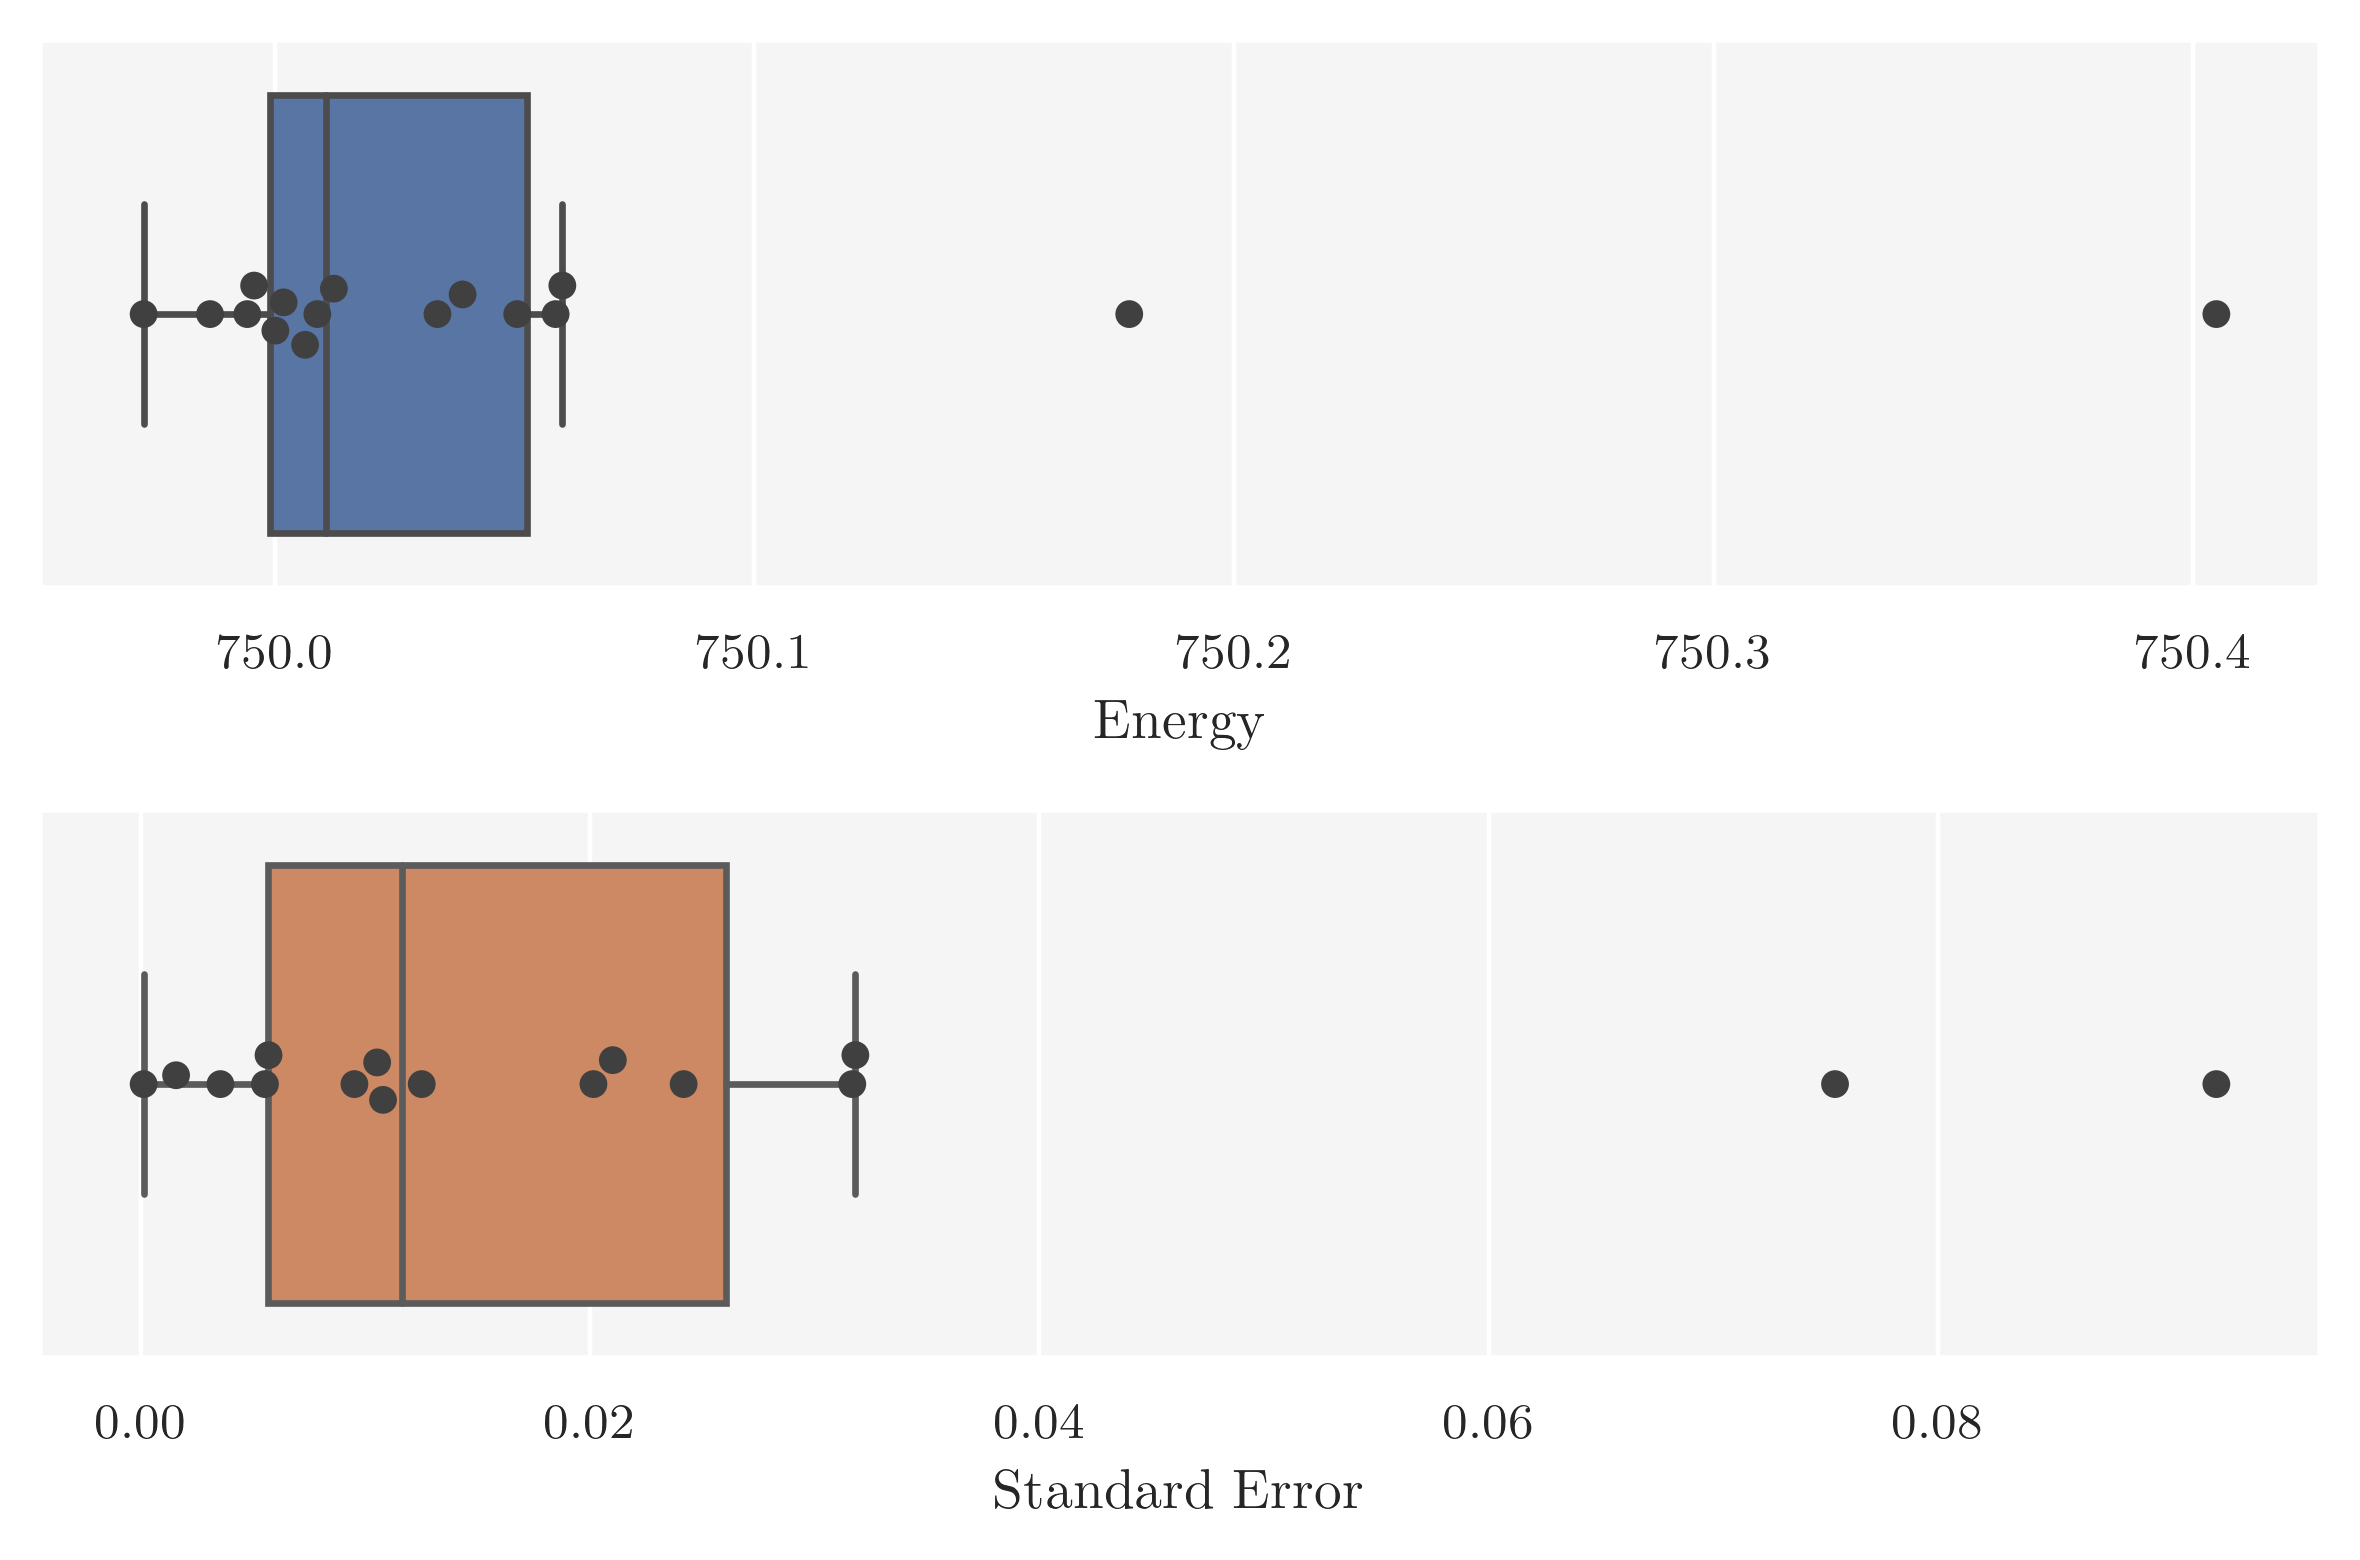

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_numerical_metropolis.pdf"), bbox_inches='tight')

plt.show()

#### Metropolis-Hastings

In [22]:
N = 500      # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Instantiate wave function
wf = vmc.LogNIB(omega)

# Set intial positions
initial_positions = safe_initial_positions(wf, alpha, N, dim)

# Instantiate sampler
sampler = vmc.samplers.MetropolisHastings(wf)

# Config
nsamples = 20000
initial_alpha = 0.4

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         nchains=nchains,
                         seed=None,
                         warm=True,
                         warmup_iter=500,
                         tune=True,
                         tune_iter=5000,
                         tune_interval=250,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=50000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         dt=0.5
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 109.6232271194458


In [23]:
df = sampler.results_all
df

,nparticles,dim,dt,eta,alpha,energy,standard_error,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,500,3,1.296871,0.01,0.506716,750.130535,0.070575,0.6899312,20000,46250,500,1750,24000
1,500,3,1.296871,0.01,0.499976,749.999933,0.000222,0.6969692,20000,72250,500,1750,50000
2,500,3,1.296871,0.01,0.500393,750.007702,0.003301,0.69057816,20000,68250,500,1750,46000
3,500,3,1.296871,0.01,0.497495,749.981304,0.022312,0.6926867,20000,58250,500,1750,36000
4,500,3,1.296871,0.01,0.506273,750.057982,0.038550,0.6890346,20000,48750,500,1750,26500
5,500,3,1.296871,0.01,0.500372,750.004468,0.002999,0.69537526,20000,72250,500,1750,50000
6,500,3,1.296871,0.01,0.497757,750.000178,0.019066,0.6963275,20000,55750,500,1750,33500
7,500,3,1.296871,0.01,0.497449,749.954612,0.015568,0.69878626,20000,52750,500,1750,30500
8,500,3,1.296871,0.01,0.499736,749.991626,0.001549,0.6911736,20000,72250,500,1750,50000
9,500,3,1.296871,0.01,0.500546,749.993066,0.004397,0.69128144,20000,69250,500,1750,47000


In [24]:
exact_E = exact_energy(N, dim, omega)
energy_mean = results["energy"].mean()
error_mean = results["standard_error"].mean()
print(f"Exact energy: {exact_E}")
print(f"VMC energy: {energy_mean}")
print(f"VMC error: {error_mean}")

Exact energy: 750.0
VMC energy: 749.9872731363297
VMC error: 0.017292838258405063


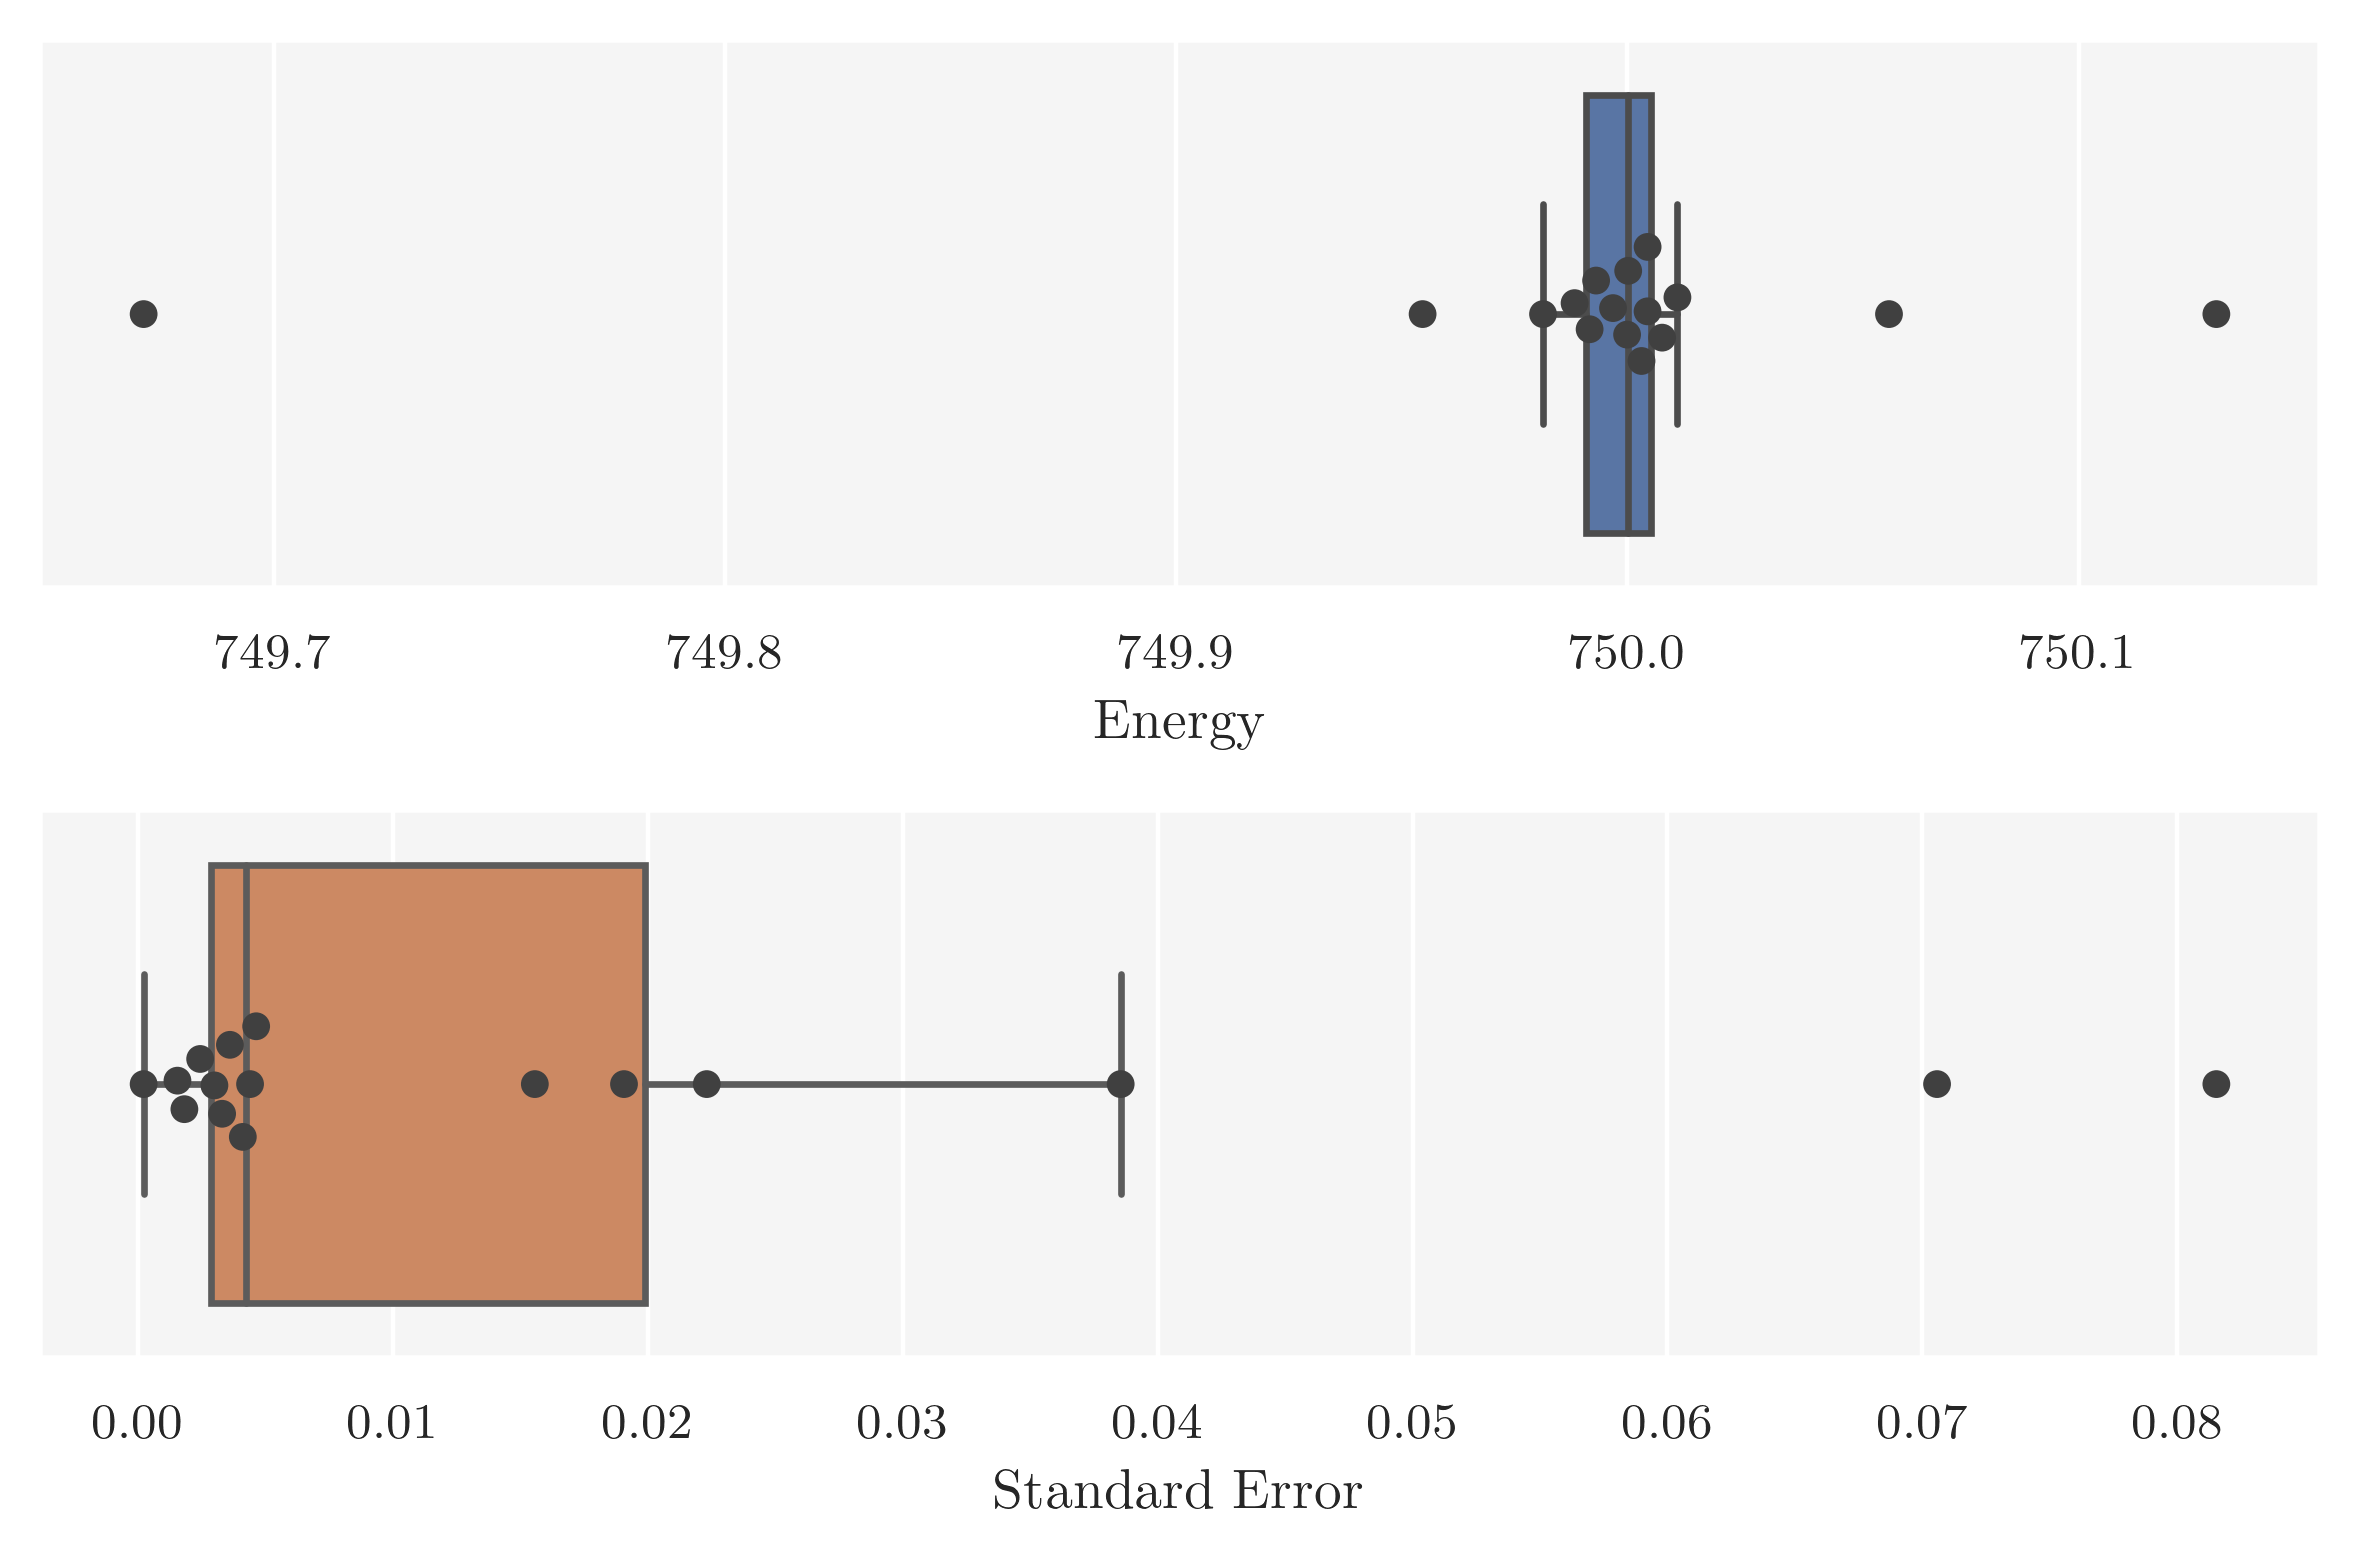

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), tight_layout=True, dpi=200)

sns.boxplot(data=df, x="energy", color="C0", fliersize=0, ax=axes[0])
sns.swarmplot(data=df, x="energy", color=".25", ax=axes[0])
axes[0].set(xlabel="Energy")

sns.boxplot(data=df, x="standard_error", color="C1", fliersize=0, ax=axes[1])
sns.swarmplot(data=df, x="standard_error", color=".25", ax=axes[1])
axes[1].set(xlabel="Standard Error")

fig.savefig(fig_path("boxplot_numerical_metropolis_hastings.pdf"), bbox_inches='tight')

plt.show()